In [1]:
import scipy

import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
import gene_tools
import os
from gene_tools import foldersLoad, cleanDic, compute_scores,geneScores, NA_filtering,evaluate_trait_scores,evaluate_OR,run_full_trait_pipeline,compare_drug_target_percentiles
from Scoring.scomet import Mean, Max, Min, Median, pca, Product

In [2]:

root_path = os.path.join('data', '00_BPStart/00_gene_prioritization')
folders = ['eQTL_GWAS_blood', 'Exome', 'GWAS','pQTL_GWAS']
raw_data = foldersLoad(root_path, folders)
merged = pd.read_csv(r"data\00_BPStart\merged_drug_all_db_with_hgnc_TTD.tsv", sep="\t")
dic_clean = cleanDic(raw_data)


In [3]:
from Scoring.scomet import Mean, Max, Min, Median, pca, Product

ldl_clean = dic_clean["LDL"]

evaluate_trait_scores(
    df = ldl_clean,
    drug_reference= merged,
    scoring_functions=[ Mean, Max, Min, Median, Product],
    score_columns=["Prioscore_mean", "Prioscore_max", "Prioscore_min", "Prioscore_median", "Prioscore_product"],
    overlap_method="topvalues",
    cutoff=0.005,
    printer=False,
    targetthreshold=3)


{'LDL': {'Prioscore_mean': 3.922,
  'Prioscore_max': 3.922,
  'Prioscore_min': 11.765,
  'Prioscore_median': 9.804,
  'Prioscore_product': 9.804}}

In [4]:
from gene_tools.analysis import evaluate_OR, run_full_trait_pipeline


TC_clean = dic_clean["TC"]


res = evaluate_OR(
    reference=merged,
    mydf=TC_clean,
    scoring_functions=[Mean, Max, Min, Median, Product],
    score_cols=[
      "Prioscore_mean", "Prioscore_max", 
      "Prioscore_min", "Prioscore_median", 
      "Prioscore_product"
    ],
    sum_threshold=3,
    cutoff=0.01,
    method="topvalues",
    printer=True
)



[TC] Prioscore_mean: OR = 6.99, p = 3.4761e-04, drug targets in top 1.0% = 6
[TC] Prioscore_max: OR = 6.99, p = 3.4761e-04, drug targets in top 1.0% = 6
[TC] Prioscore_min: OR = 22.19, p = 1.1043e-15, drug targets in top 1.0% = 16
[TC] Prioscore_median: OR = 18.72, p = 4.8650e-13, drug targets in top 1.0% = 14
[TC] Prioscore_product: OR = 17.08, p = 8.9906e-12, drug targets in top 1.0% = 13


In [5]:
def get_best_trait_method(finaldic):
    best_trait = None
    best_method = None
    best_or = -float('inf')

    for trait, res in finaldic.items():
        for method, (or_val, p_val, n) in res['OR_eval'].items():
            if or_val > best_or:
                best_or = or_val
                best_trait = trait
                best_method = method

    return best_trait, best_method, best_or

print(f"For 0.5% : ")
finaldic = run_full_trait_pipeline(dic_clean,drug_reference=merged,scoring_functions = [Mean, Max, Min, Median, Product],
                                   evaluate_or_fn=evaluate_OR,evaluate_score_fn=evaluate_trait_scores,
                        score_kwargs={"cutoff": 0.005,"overlap_method": "topvalues"},or_kwargs = {"score_cols" : ["Prioscore_mean", "Prioscore_max", "Prioscore_min", "Prioscore_median","Prioscore_product"],
                        "method" : "topvalues","cutoff":0.005}
                        ,verbose = False)
print(get_best_trait_method(finaldic))



print(f"for 1%: ")
finaldic = run_full_trait_pipeline(dic_clean,drug_reference=merged,scoring_functions = [Mean, Max, Min, Median, Product],
                                   evaluate_or_fn=evaluate_OR,evaluate_score_fn=evaluate_trait_scores,
                        score_kwargs={"cutoff": 0.01,"overlap_method": "topvalues"},or_kwargs = {"score_cols" : ["Prioscore_mean", "Prioscore_max", "Prioscore_min", "Prioscore_median","Prioscore_product"],
                        "method" : "topvalues","cutoff":0.01}
                        ,verbose = False)
print(get_best_trait_method(finaldic))

print(f"for 5%: ")

finaldic = run_full_trait_pipeline(dic_clean,drug_reference=merged,scoring_functions = [Mean, Max, Min, Median, Product],
                                   evaluate_or_fn=evaluate_OR,evaluate_score_fn=evaluate_trait_scores,
                        score_kwargs={"cutoff": 0.05,"overlap_method": "topvalues"},or_kwargs = {"score_cols" : ["Prioscore_mean", "Prioscore_max", "Prioscore_min", "Prioscore_median","Prioscore_product"],
                        "method" : "topvalues","cutoff":0.05}
                        ,verbose = False)

print(get_best_trait_method(finaldic))


For 0.5% : 
('TC', 'Prioscore_min', np.float64(48.756))
for 1%: 
('TC', 'Prioscore_min', np.float64(22.191))
for 5%: 
('TC', 'Prioscore_min', np.float64(6.758))


In [6]:
finaldic = run_full_trait_pipeline(dic_clean,drug_reference=merged,scoring_functions = [Mean, Max, Min, Median, Product],
                                   evaluate_or_fn=evaluate_OR,evaluate_score_fn=evaluate_trait_scores,
                        score_kwargs={"cutoff": 0.005,"overlap_method": "topvalues"},or_kwargs = {"score_cols" : ["Prioscore_mean", "Prioscore_max", "Prioscore_min", "Prioscore_median","Prioscore_product"],
                        "method" : "topvalues","cutoff":0.005}
                        ,verbose = False)

finaldic["TC"]


{'data':              EnsemblId Trait  eQTL_percentile  Exome_percentile  \
 0      ENSG00000000003    TC              NaN         13.329790   
 1      ENSG00000000005    TC              NaN          2.684029   
 2      ENSG00000000419    TC        77.776011         35.997874   
 3      ENSG00000000457    TC        45.242826         41.174595   
 4      ENSG00000000460    TC        45.695891          7.036939   
 ...                ...   ...              ...               ...   
 20428  ENSG00000283619    TC              NaN          9.577465   
 20429  ENSG00000283623    TC              NaN         21.413766   
 20430  ENSG00000283652    TC              NaN         73.935690   
 20431  ENSG00000283683    TC              NaN         96.332713   
 20432  ENSG00000283697    TC              NaN         49.460537   
 
        GWAS_percentile  pQTL_percentile  Prioscore_mean  Prioscore_max  \
 0                  NaN              NaN       13.329790      13.329790   
 1                  NaN 

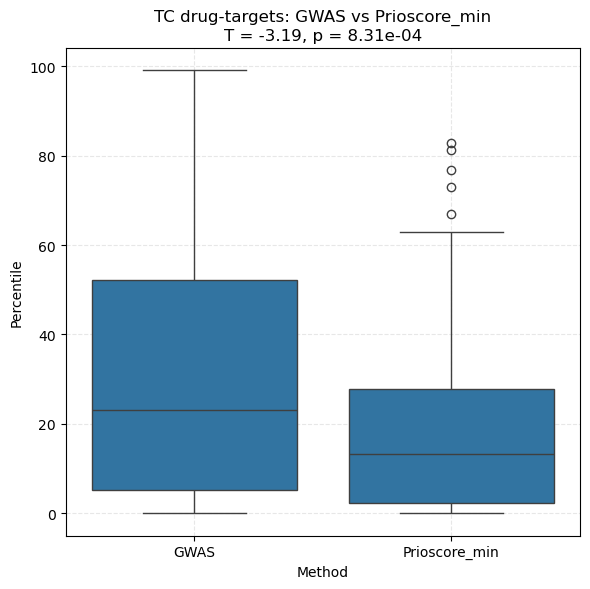

(np.float64(-3.1910761658790836), np.float64(0.000830655034385012))

In [7]:
from gene_tools import compare_drug_target_percentiles
TC = finaldic["TC"]["data"]
compare_drug_target_percentiles(
    df=TC,
    merged=merged,
    trait="TC",
    reference_method="GWAS",
    method="min",
    targetthreshold=3
)
